In [3]:
import os
import os.path
import sys

p_mod=os.path.join(os.environ['HOME'],'notebooks/99MyModules')
sys.path.append(p_mod)

## 1. ライブラリのインポート
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
print(rdBase.rdkitVersion) # 2019.03.2

2019.03.2


In [4]:
import descarray as da

In [5]:
df_AMES=pd.read_csv('./ci900161g_si_001/smiles_cas_N6512.smi',sep='\t', header=None)
df_AMES.columns = ['smiles', 'CAS_NO', 'activity']
da.descDf(df_AMES)

サイズ:(6512, 3)


,smiles,CAS_NO,activity
0,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7cccc...,2475-33-4,0
1,NNC(=O)CNC(=O)\C=N\#N,820-75-7,1
2,O=C1NC(=O)\C(=N/#N)\C=N1,2435-76-9,1
3,NC(=O)CNC(=O)\C=N\#N,817-99-2,1
4,CCCCN(CC(O)C1=C\C(=N/#N)\C(=O)C=C1)N=O,116539-70-9,1


サイズ:(6512, 4)


,smiles,CAS_NO,activity,ROMol
0,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7ccccc7C(=O)c6c8[nH]c9c%10C(=O)c%11ccccc%11C(=O)c%10ccc9c8c45,2475-33-4,0,
1,NNC(=O)CNC(=O)\C=N\#N,820-75-7,1,None
2,O=C1NC(=O)\C(=N/#N)\C=N1,2435-76-9,1,None
3,NC(=O)CNC(=O)\C=N\#N,817-99-2,1,None
4,CCCCN(CC(O)C1=C\C(=N/#N)\C(=O)C=C1)N=O,116539-70-9,1,None

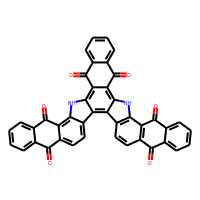

In [6]:
PandasTools.AddMoleculeColumnToFrame(frame=df_AMES, smilesCol='smiles')
da.descDf(df_AMES)

サイズ:(6506, 5)


,smiles,CAS_NO,activity,ROMol,mw
0,O=C1c2ccccc2C(=O)c3c1ccc4c3[nH]c5c6C(=O)c7ccccc7C(=O)c6c8[nH]c9c%10C(=O)c%11ccccc%11C(=O)c%10ccc9c8c45,2475-33-4,0,,646.614
7,CC(=O)OC1(CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)C3CCC12C)C(=O)C,105149-00-6,0,,406.906
8,Nc1nc(N)nc(N)n1,108-78-1,0,,126.123
9,Cc1ccc(N=Nc2c(O)ccc3ccccc23)c(c1)[N+](=O)[O-],2425-85-6,1,,307.309
10,CC(C)CC(=O)Nc1snc2ccccc12,67019-24-3,0,,234.324

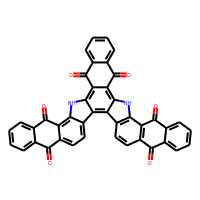
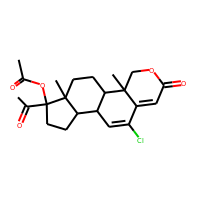
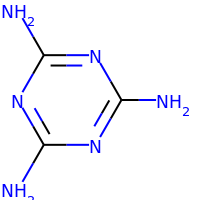
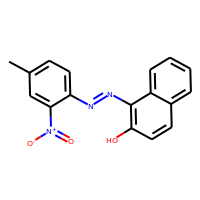
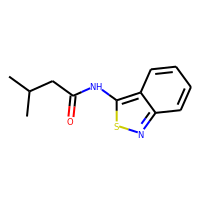

In [7]:
## 4. 読み込めない分子の削除
df_AMES_d=df_AMES.dropna()
df_AMES_d=df_AMES_d.assign(mw=df_AMES_d['ROMol'].map(Descriptors.MolWt))#.map(Descriptors.MolWt)
da.descDf(df_AMES_d)

In [8]:
print('全部で%d'%len(df_AMES_d)) # 6506
n_neg=np.sum(df_AMES_d.activity == 0)
n_pos=np.sum(df_AMES_d.activity == 1)
print('陰性は{}、陽性は{}'.format(n_neg,n_pos))

全部で6506
陰性は3009、陽性は3497


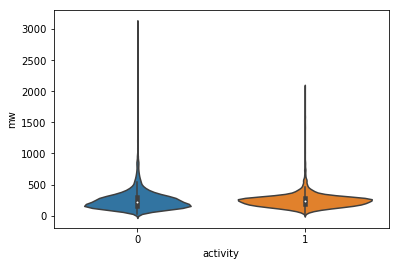

In [9]:
## 5. 分子量分布をプロット
sns.violinplot(x='activity', y='mw', data=df_AMES_d)

In [10]:
## モルガンフィンガープリント
morgan_fp = []
for mol in df_AMES_d.ROMol:
    fp = [i for i in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
    morgan_fp.append(fp)
morgan_fp = np.array(morgan_fp)
print(morgan_fp.shape) # (6506, 2048)
## MACCS Keys
maccskeys = []
for mol in df_AMES_d.ROMol:
    maccskey = [i for i in AllChem.GetMACCSKeysFingerprint(mol)]
    maccskeys.append(maccskey)
maccskeys = np.array(maccskeys)
print(maccskeys.shape) # (6506, 167)
## 出力ラベル
target = df_AMES_d.activity
print(target.shape) # (6506,)

(6506, 2048)
(6506, 167)
(6506,)


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(morgan_fp, target, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4879, 2048) (1627, 2048) (4879,) (1627,)


In [12]:
from sklearn.neighbors import KNeighborsClassifier
morgan_train_acc = []
morgan_test_acc = []
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    print('test accuracy with k={}: {:.3f}'.format(i, test_acc))
    morgan_train_acc.append(train_acc)
    morgan_test_acc.append(test_acc)

test accuracy with k=1: 0.750
test accuracy with k=2: 0.739
test accuracy with k=3: 0.783
test accuracy with k=4: 0.768
test accuracy with k=5: 0.787
test accuracy with k=6: 0.773
test accuracy with k=7: 0.779
test accuracy with k=8: 0.773
test accuracy with k=9: 0.776
test accuracy with k=10: 0.772


In [13]:
import threading

In [18]:
def calcknn1():
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    print('test accuracy with k={}: {:.3f}'.format(i, test_acc))
    morgan_train_acc.append(train_acc)
    morgan_test_acc.append(test_acc)
    
def calcknn2():
    knn = KNeighborsClassifier(n_neighbors=2)
    knn.fit(X_train, y_train)
    train_acc = knn.score(X_train, y_train)
    test_acc = knn.score(X_test, y_test)
    print('test accuracy with k={}: {:.3f}'.format(i, test_acc))
    morgan_train_acc.append(train_acc)
    morgan_test_acc.append(test_acc)

In [19]:
thread_1 = threading.Thread(target=calcknn1)
thread_2 = threading.Thread(target=calcknn2)

In [20]:
thread_1.start()
thread_2.start()

test accuracy with k=10: 0.750
test accuracy with k=10: 0.739


In [84]:
np.sum(df_AMES_d.isnull())

smiles      0
CAS_NO      0
activity    0
ROMol       0
mw          0
dtype: int64

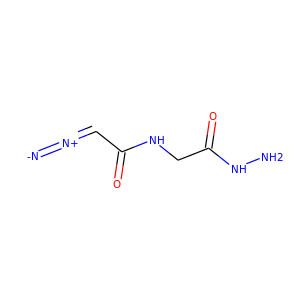

In [25]:
CSO2C = Chem.MolFromSmiles('CS(=O)(=O)C')
Draw.MolToImage(Chem.MolFromSmiles('NNC(=O)CNC(=O)C=N#N'))

,smiles,CAS_NO,activity,ROMol
379,CC(=O)Nc1ccc(cc1)S(=O)(=O)c2ccc(NC(=O)C)cc2,77-46-3,0,
406,Clc1ccc(cc1)S(=O)(=O)c2ccc(Cl)cc2,80-07-9,0,
768,CS(=O)(=O)c1ccc(O)c(N)c1,98-30-6,0,
1025,Nc1c2C(=O)c3ccccc3C(=O)c2c(Nc4cccc(c4)S(=O)(=O)CCOS(=O)(=O)O)cc1S(=O)(=O)O,2580-78-1,1,
1042,C[C@H]1CS(=O)(=O)CCN1\N=C\c2oc(cc2)[N+](=O)[O-],NOCAS_M93,1,
1153,O=S1(=O)CCCC1,126-33-0,0,
2590,Nc1ccc(cc1)S(=O)(=O)c2ccc(N)cc2,80-08-0,0,
2814,O=S1(=O)CC=CC1,77-79-2,0,
3262,CC(C)(C)S(=O)(=O)CC(Cc1ccccc1)C(=O)NC(Cc2c[nH]cn2)C(=O)NC(CC3CCCCC3)C(O)C(O)C4CC4,126222-34-2,0,
4100,CC(C)CCC[C@@H](C)[C@@H]1CC[C@@H]2[C@@H]3CC4([C@@H]5C[C@@H](Br)CC[C@]5(C)[C@@H]3CC[C@]12C)S(=O)(=O)CCS4(=O)=O,133331-34-7,1,

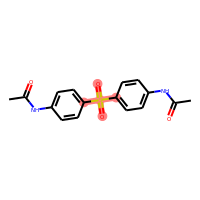
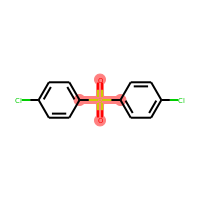
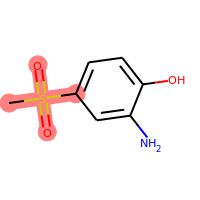
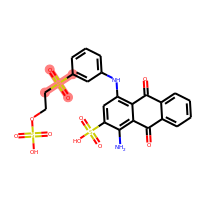
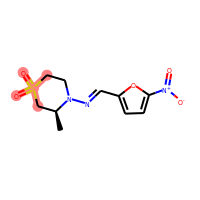
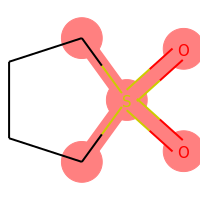
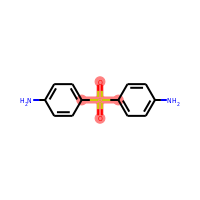
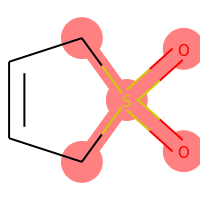
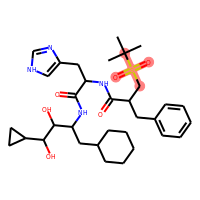
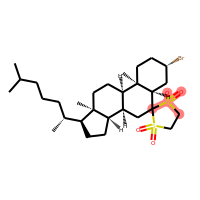
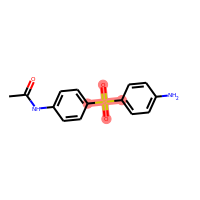
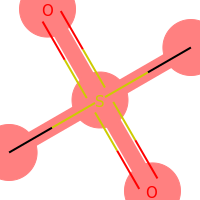
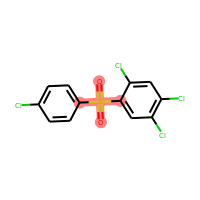
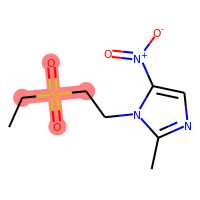
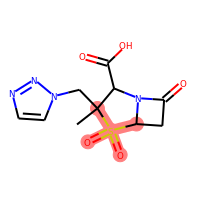
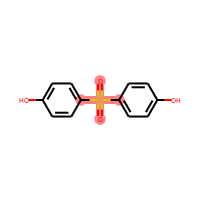
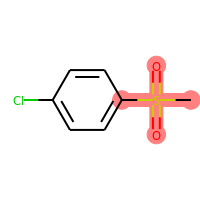
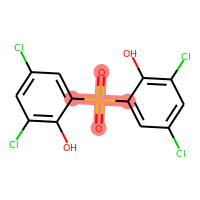
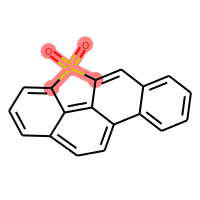
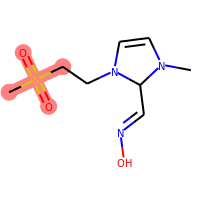

In [15]:
df_AMES[df_AMES.ROMol >= CSO2C]

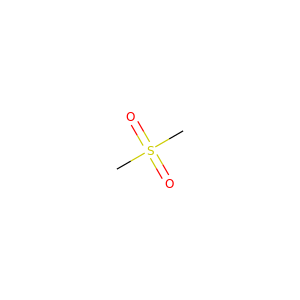

In [21]:
Draw.MolToImage(CSO2C)

In [18]:
type(df_AMES.ROMol[0])

rdkit.Chem.rdchem.Mol